# Exploration of user feedback data

This notebook contains analysis performed as part of technical exercise for the position of Data Scientist with GDS Product Group.

Notebook structure:
* Section 1: Investigating the dataset
* Section 2: Data augmentation
* Section 3: Detecting themes in user feedback

In [1]:
import time

import altair
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from theme_explorer.llm.llm_synthetic import SyntheticSurvey
from theme_explorer.utils.text_cleaning import clean_text, flag_spam_content

## Section 1: Investigating the dataset

### Load provided dataset

In [2]:
data = pd.read_csv("../data/raw/feedback_data.csv")

In [3]:
data.describe()

,Feedback,Sentiment
count,51,51
unique,50,2
top,The page loads are too slow and it frustrates ...,Negative
freq,2,27


Quick look at the dataset shows that it contains two variables: `Feedback` and `Sentiment`. The `Feedback` is typically is a short sentence and the `Sentiment` is a binary label.

It also appears that some `Feedback` values are duplicates.

In [4]:
# Look at a few randomly selected examples
data.sample(3).T

,30,44,19
Feedback,The interactive tool helped me calculate my po...,Font size is too small on some informational p...,The step-by-step guide for applying was perfec...
Sentiment,Positive,Negative,Positive


In [5]:
# Check Sentiment distribution
data["Sentiment"].value_counts()


Sentiment
Negative    27
Positive    24
Name: count, dtype: int64

In the provided fictional dataset positive and negative sentiment labels are represented fairly equally.

<Axes: xlabel='feedback_length', ylabel='Count'>

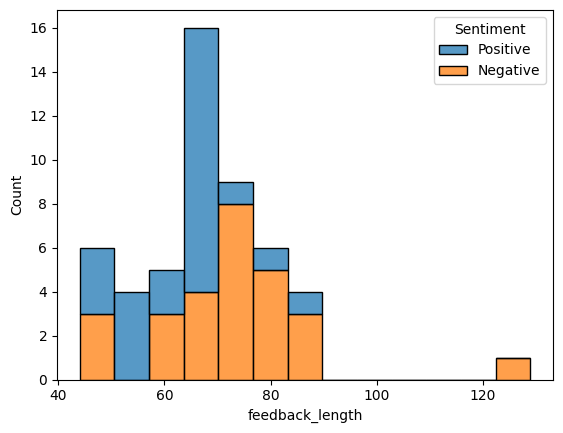

In [6]:
# Check distribution of feedback length
data['feedback_length'] = data['Feedback'].str.len()

# Plot the distribution of feedback lengths broken down by sentiment type
sns.histplot(data=data, x='feedback_length', hue='Sentiment', multiple='stack')

In [7]:
print(f'The median length of feedback is {data["feedback_length"].median()} ')
print(f'For negative feedback this values is {data[data["Sentiment"]== "Negative"]["feedback_length"].median()} characters')
print(f'For positive feedback the median length of feedback is {data[data["Sentiment"]== "Positive"]["feedback_length"].median()} characters')

The median length of feedback is 68.0 
For negative feedback this values is 72.0 characters
For positive feedback the median length of feedback is 64.5 characters


Positive feedback appears to be longer than negative. At the same time there are outliers for negative feedback that are noticeably longer.

## Section 2: Data augmentation

### Data pre-processing

From initial exploration of the dataset I identified some issues that make it necessary to clean and pre-process the data:
* Duplicated feedback entries. These entries need to be removed so that they do not skew sentiment distribution.
* Presence of potentially personally identifiable information (PII) in the form of phone numbers and emails. PII needs to be masked to avoid disclosure and protect users' privacy.
* Presence of irrelevant entries, such as spam. These entries need to be filtered out as they do not represent user feedback.

To address these issues, I have taken the following pre-processing steps:
* Removed duplicates
* Detected and masked potential PII based on patterns (special characters that indicate emails, series of numeric characters resembling phone numbers, capitalisation patterns that might refer to names)
* Flagged potential spam based on patterns (presence of urls, atypical capitalisation)

Also, to address potential issues with data quality coming from web sources, I have also removed punctuation, standardised whitespaces, checked for encoding issues and converted text to lower case.

To ensure readability of the notebook and in line with best practice of writing modular code, I have put most of the pre-processing code into the `text_cleaning` module. The module is included in the `theme_explorer` git repo folder attached to this submission.

In [8]:
data["clean_feedback"] = clean_text(data["Feedback"])

In [9]:
data["spam_flag"] = flag_spam_content(data["Feedback"])

In [10]:
# Check known spam entry
data.loc[48]

Feedback           BUY CHEAP DRUGS ONLINE NOW www.fakepharma.biz
Sentiment                                               Negative
feedback_length                                               45
clean_feedback     buy cheap drugs online now www fakepharma biz
spam_flag                                                   True
Name: 48, dtype: object

In [11]:
# Filter out spam entries and duplicates
data = data[~data["spam_flag"]]
data = data.drop_duplicates(subset=["Feedback"])

### Data augmentation

For data augmentation I used Claude Large Language Model (LLM) to programmatically generate synthetic data using an API. 

This involved:
* Defining prompt template (see `src/theme_explorer/llm/prompt_synthetic.py`). This enables editing prompts in a systematic way.
* Specifying requirements for the LLM output using Pydantic (see `src/theme_explorer/llm/synthetic_response.py`). Having a data model for the LLM response helps to ensure that LLM output is returned in a structured format for subsequent processing.
* Defining a function to prepare and send the prompt and additional information to LLM (see `src/theme_explorer/llm/llm_synthetic.py`)

LLM prompt includes pairs of feedback with negative and positive sentiment. This is done as part of few shot prompting to make LLM-generated data more realistic. 


In [12]:
concept_definitions = """'Feedback' is a response from the user of a web-site or an app describing their experience. 
It contains on average one short sentence (70 characters).
'Sentiment' is a label referring to the sentiment of the feedback. It can be Negative or Positive'. """

In [13]:
# List of positive examples as a dict
positive_examples = data[data["Sentiment"] == "Positive"].to_dict(orient="records")
negative_examples = data[data["Sentiment"] == "Negative"].to_dict(orient="records")

In [14]:
survey = SyntheticSurvey(model_name="claude-sonnet-4-20250514")

example_pairs = list(zip(positive_examples, negative_examples))

response_dfs = []
for i, pair in enumerate(example_pairs):
    responses = survey.get_synthetic_response(
        concept1="user feedback",
        concept2="sentiment", 
        definitions=concept_definitions,
        examples=pair, 
        instructions="Generate 10 new user feedback responses with sentiment labels",
    )
    
    time.sleep(10)  # Wait to avoid rate limiting
    
    # Convert response to dictionary and create a DataFrame
    response_data = [{"feedback": item.feedback, "sentiment": item.sentiment} for item in responses.responses]
    response_dfs.append(pd.DataFrame(response_data))
    

/Users/jdjumalieva/theme_explorer/src/theme_explorer/llm/llm_synthetic.py:62: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=self.llm, prompt=self.prompt)


In [15]:
# Now responses is a SyntheticResponse object
print(f"Here are {len(responses.responses)} sample feedback items")

# Access individual feedback items
for item in responses.responses[:5]:
    print(f"Feedback: {item.feedback}")
    print(f"Sentiment: {item.sentiment}")
    print("---")

Here are 10 sample feedback items
Feedback: Navigation menu is confusing and hard to find what I need
Sentiment: Negative
---
Feedback: Love the clean design and intuitive layout!
Sentiment: Positive
---
Feedback: Site loads super fast, great performance overall
Sentiment: Positive
---
Feedback: Text is too small and difficult to read on mobile
Sentiment: Negative
---
Feedback: Search function works perfectly and finds exactly what I want
Sentiment: Positive
---


In [16]:
synthetic_df = pd.concat(response_dfs)

In [17]:
synthetic_df.describe()

,feedback,sentiment
count,240,240
unique,227,2
top,The navigation menu is confusing and hard to f...,Positive
freq,3,120


There are a few duplicated entries in the synthetic dataset.

In [18]:
synthetic_df["sentiment"].value_counts()

sentiment
Positive    120
Negative    120
Name: count, dtype: int64

Synthetic data maintains balance between negative and positive sentiment labels.

<Axes: xlabel='feedback_length', ylabel='Count'>

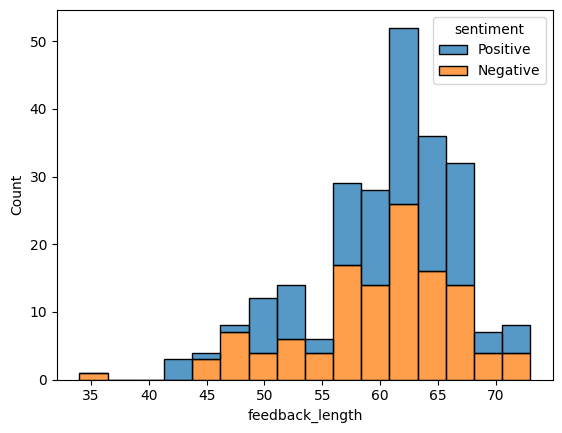

In [19]:
# Check distribution of feedback length
synthetic_df['feedback_length'] = synthetic_df['feedback'].str.len()

# Plot the distribution of feedback lengths broken down by sentiment type
sns.histplot(data=synthetic_df, x='feedback_length', hue='sentiment', multiple='stack')

In [20]:
print(f'The median length of synthetic feedback is {synthetic_df["feedback_length"].median()} ')
print(f'For negative feedback this values is {synthetic_df[synthetic_df["sentiment"]== "Negative"]["feedback_length"].median()} characters')
print(f'For positive feedback the median length of feedback is {synthetic_df[synthetic_df["sentiment"]== "Positive"]["feedback_length"].median()} characters')

The median length of synthetic feedback is 62.0 
For negative feedback this values is 61.0 characters
For positive feedback the median length of feedback is 62.0 characters


While synthetic data has a similar distribution of feedback length across sentiment, more work is needed to check that synthetic data is not materially different from the original dataset.

In [21]:
synthetic_df.to_csv("../outputs/synthetic_feedback_data_2025-06-14.csv", index=False)

## Section 3: Detecting themes in user feedback

Once we have accumulated a larger dataset of user feedback, we can start exploring possible themes.

Below are some examples of analysis that we could perform for this purpose.

### Example 1: Identifying top terms across negative and positive feedback

In this example I use very simple counts of common terms across negative and positive feedback.

In [22]:
data.rename(columns={"Feedback": "feedback", "Sentiment": "sentiment"}, inplace=True)

In [23]:
synthetic_df["clean_feedback"] = clean_text(synthetic_df["feedback"])

In [24]:
# Combine original data and synthetic data
combined_data = pd.concat([data[["feedback", "sentiment", "clean_feedback"]], synthetic_df], ignore_index=True)

In [25]:
combined_data = combined_data.drop_duplicates(subset=["feedback"])

In [26]:
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
counts = vectorizer.fit(combined_data["clean_feedback"])

In [27]:
# Identify most frequent ngrams in counts
positive_feedback = combined_data[combined_data["sentiment"] == "Positive"]
negative_feedback = combined_data[combined_data["sentiment"] == "Negative"]
top_ngrams_pos = pd.DataFrame(counts.transform(positive_feedback["clean_feedback"]).toarray(), 
                          columns=counts.get_feature_names_out()).sum().sort_values(ascending=False).head(25)
top_ngrams_neg = pd.DataFrame(counts.transform(negative_feedback["clean_feedback"]).toarray(),
                            columns=counts.get_feature_names_out()).sum().sort_values(ascending=False).head(25)

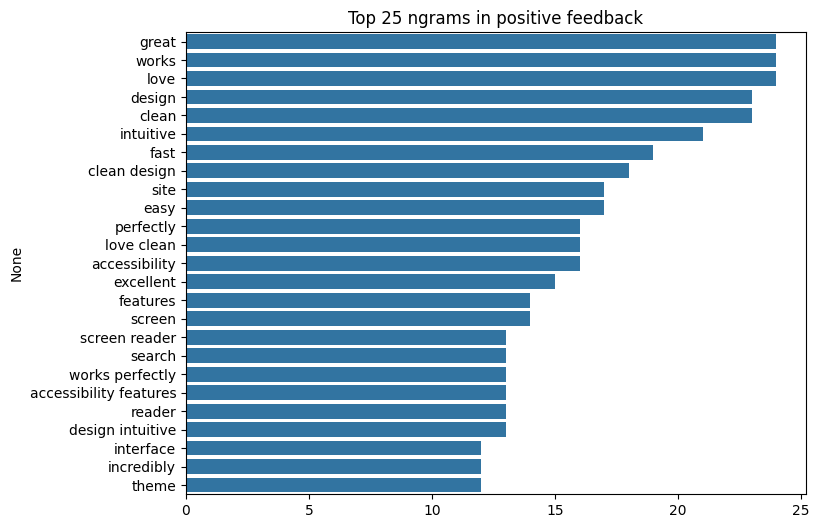

In [28]:
# Plot most popular 25 ngrams in positive feedback
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(x=top_ngrams_pos.values, y=top_ngrams_pos.index)
ax.set_title("Top 25 ngrams in positive feedback")
plt.savefig("../outputs/top_ngrams_pos.png")

Reviewing top terms in positive feedback can help us understand aspects of user experience that work well (e.g. 'search', 'design`).

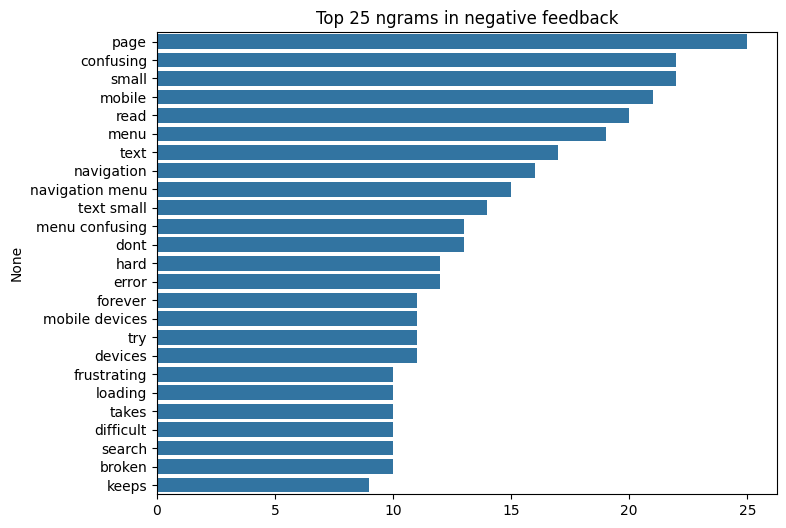

In [29]:
# Plot most popular 25 ngrams in negative feedback
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.barplot(x=top_ngrams_neg.values, y=top_ngrams_neg.index)
ax.set_title("Top 25 ngrams in negative feedback")
plt.savefig("../outputs/top_ngrams_neg.png")

Similarly, looking at top terms in negative feedback enables us to spot potential issues (e.g. 'navigation menu', 'text small')

### Example 2: Cluster feedback

In this example, we embed feedback sentences using `sentence-transformers` package, cluster them using HDBSCAN method and then visualise clusters using UMAP 2-d projections.

In [30]:
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [31]:
feedback_embeddings = model.encode(list(combined_data["clean_feedback"]),)

reducer = umap.UMAP(n_components = 2, random_state =1)
feedback_embeddings_2d = reducer.fit_transform(feedback_embeddings)

/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [32]:
# Low dim embeddings
reducer_clustering = umap.UMAP(n_components = 20, random_state =1)
feedback_embeddings_clustering = reducer_clustering.fit_transform(feedback_embeddings)

/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [33]:
# Df for altair plotting
col_df = pd.DataFrame({
    'feedback': list(combined_data["clean_feedback"]),
    'x': feedback_embeddings_2d[:, 0],
    'y': feedback_embeddings_2d[:, 1],

    })

In [34]:
# Cluster with hdbscan
clusterer = hdbscan.HDBSCAN(
    min_cluster_size = 2,
    min_samples = 2,
    cluster_selection_method='leaf'
)
clusterer.fit(feedback_embeddings_clustering)

/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jdjumalieva/theme_explorer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,2
,min_samples,2
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [35]:
col_df['cluster'] = [str(x) for x in clusterer.labels_]

In [36]:
fig = (
    altair.Chart(col_df, width = 800, height = 800, title="Feedback clusters")
    .mark_circle(size = 60)
    .encode(
        x="x", y="y", tooltip=["feedback", "cluster"],
        color=altair.Color("cluster", scale=altair.Scale(scheme='category20')) 
    ) 
).interactive()

fig.configure_title(fontSize=24)

alt.Chart(...)

In [37]:
fig.save("../outputs/feedback_clusters_2025-06-14.html")

Clustering feedback and profiling resulting clusters can help us detect themes we may not be aware of. It can also serve for validation purposes to compare to outputs from another method, such as LLM theme detection and summarisation.